<strong><h3>Design of word embeddings using Word2vec (N-gram) and using it for sentiment analysis</h3></strong>

In [130]:
import string 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import sent_tokenize
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from gensim.utils import simple_preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , precision_score ,  confusion_matrix
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB , CategoricalNB
 

In [131]:
df = pd.read_csv("Sentiment analysis/TheSocialDilemma.csv")
df = df[['text' , 'Sentiment']].copy()
df.sample(5)

,text,Sentiment
2752,Scary to think that I’m part of the last gener...,Negative
8776,A few tips from the tech experts who earlier w...,Positive
7208,The documentary to watch right now “The Social...,Negative
18975,They want us to go to their apps and spend som...,Neutral
7937,#TheSocialDilemma had nothing new. It just rem...,Positive


In [132]:
df.isnull().sum()

text         0
Sentiment    0
dtype: int64

In [133]:
df.duplicated().sum()
df.drop_duplicates(keep = "first" , inplace= True)
df.duplicated().sum()

0

In [134]:
df.shape

(19850, 2)

<Axes: ylabel='count'>

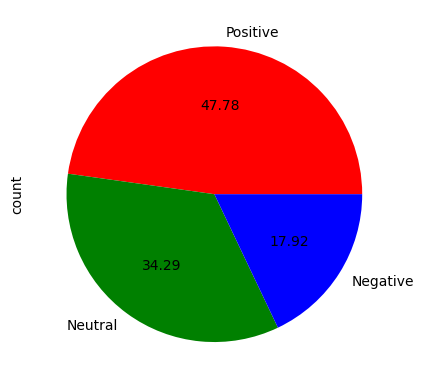

In [135]:
# EDA
df['Sentiment'].value_counts().plot(kind= "pie" , autopct = "%.2f" , colors=["r", "g", "b"] )

In [136]:
# Data preprocessing of text data
import re
lem = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

def preprocessing(text):
    text = text.lower() # Lowercase the word

    # lemmatization , stop words removal and punctuation removal
    filter_words = [lem.lemmatize(word) for word in text.split() if word not in stop_words and word not in string.punctuation] 

    filter_word_final = [word for word in filter_words if word.isalnum()] # removing spcial chracter
   
    return " ".join(filter_word_final)

df['text'] = df['text'].apply(preprocessing)

In [137]:
wc = WordCloud(width = 750 , height = 750 , min_font_size = 15 , background_color = 'black')
wc_neg = WordCloud(width = 750 , height = 750 , min_font_size = 15 , background_color = 'black')
wc_neu = WordCloud(width = 750 , height = 750 , min_font_size = 15 , background_color = 'black')

wc_positive = wc.generate(df[df['Sentiment'] == "Positive"]['text'].str.cat(sep = " "))
wc_negative = wc_neg.generate(df[df['Sentiment'] == "Negative"]['text'].str.cat(sep = " "))
wc_neutral = wc_neu.generate(df[df['Sentiment'] == "Neutral"]['text'].str.cat(sep = " "))

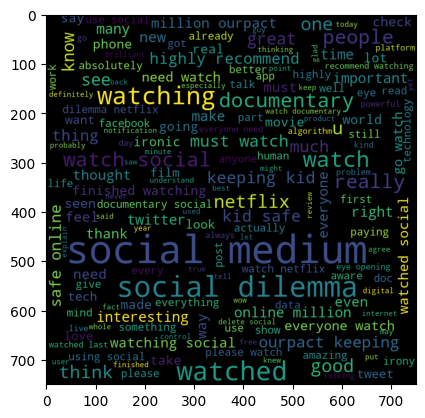

In [138]:
# positive sentiment wordcloud 
plt.imshow(wc_positive) 

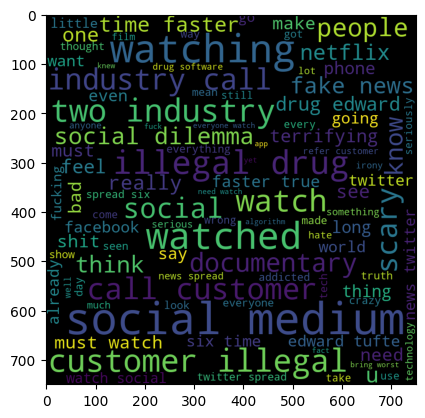

In [139]:
# Negative sentiment wordcloud 
plt.imshow(wc_negative) 

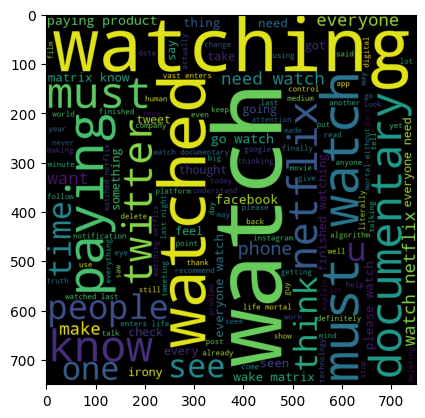

In [140]:
# Neutra; sentiment wordcloud 
plt.imshow(wc_neutral) 

In [141]:
# Creating the corpus 
corpus = []

for text in df['text']:
    raw_sent = sent_tokenize(text)
    for sent in raw_sent: 
        corpus.append(simple_preprocess(sent))

In [142]:
# Building gensim Model 
model = gensim.models.Word2Vec(\
    window= 20,
    min_count= 2
    )

In [143]:
model.build_vocab(corpus)

# Traning the model
model.train(corpus , total_examples= model.corpus_count , epochs= model.epochs)

(425677, 543230)

In [144]:
len(model.wv.index_to_key)

4373

In [145]:
# Function to convert text into vector
def docu_vector(doc):
    doc_words = [word for word in doc.split() if word in model.wv.index_to_key]
    if doc_words:
        return np.mean(model.wv[doc_words], axis=0)
    else:
        return None


In [146]:
docu_vector(df['text'].values[0]).shape

(100,)

In [147]:
# transforming the data
from tqdm import tqdm

X = []
for doc in tqdm(df['text'].values):
    X.append(docu_vector(doc))

100%|██████████| 19850/19850 [00:01<00:00, 12334.41it/s]


In [148]:
# Removing Empty list
y = df['Sentiment']

# label Encoder
lb = LabelEncoder()
y = lb.fit_transform(y)

X_filtered = []
y_filtered = []
for i, vector in enumerate(X):
    if vector is not None:
        X_filtered.append(vector)
        y_filtered.append(y[i])


X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)


In [149]:
X = X_filtered
y = y_filtered

In [150]:
# Train test split of the data

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
len(X_train) , len(X_test)

(15631, 3908)

In [157]:
# ML Classification models

# mlb = MultinomialNB()
svc = SVC(kernel= 'sigmoid')
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=50 , random_state=2)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(n_estimators=50 , random_state=2)
bc = BaggingClassifier(n_estimators=50 , random_state=2)
etc = ExtraTreesClassifier(n_estimators=50 , random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50 , random_state=2)
dtc = DecisionTreeClassifier(max_depth=6)

In [158]:
classifier = {
    'LogisticRegression' : lr,
    'SupportVectorClassifier' : svc,
    'RandomForestClassifier' : rfc,
    'KNeighborsClassifier' : knc,
    'AdaBoostClassifier' : abc,
    "BaggingClassifier" : bc,
    'ExtraTreesClassifier' : etc , 
    'GradientBoostingClassifier' : gbdt, 
    'DecisionTreeClassifier' : dtc
}

In [159]:
def apply_model(clf , X_train , y_train ,  X_test , y_test):
    clf.fit(X_train , y_train )
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_true = y_test , y_pred= y_pred)
    preci = precision_score(y_true = y_test , y_pred= y_pred , average= "weighted")

    return acc , preci

In [160]:

accuracy_sc = []
precision_sc = []

for name,clf in classifier.items():
    acc_current , prec_current = apply_model(clf , X_train , y_train ,  X_test , y_test)

    print("for : " , name)
    print("accuracy score : " , acc_current)
    print("precision score : " , prec_current)
    accuracy_sc.append(acc_current)
    precision_sc.append(prec_current)

for :  LogisticRegression
accuracy score :  0.6033776867963152
precision score :  0.6164802143324571
for :  SupportVectorClassifier
accuracy score :  0.4201637666325486
precision score :  0.44722410025877474
for :  RandomForestClassifier
accuracy score :  0.6384339815762539
precision score :  0.6250608268905113
for :  KNeighborsClassifier
accuracy score :  0.5839303991811668
precision score :  0.5812521272922453
for :  AdaBoostClassifier
accuracy score :  0.5990276356192425
precision score :  0.618332237814348
for :  BaggingClassifier
accuracy score :  0.6325486182190379
precision score :  0.6157678979135784
for :  ExtraTreesClassifier
accuracy score :  0.6333162743091095
precision score :  0.6166806180306983
for :  GradientBoostingClassifier
accuracy score :  0.6223132036847492
precision score :  0.6469372276732647
for :  DecisionTreeClassifier
accuracy score :  0.5954452405322416
precision score :  0.6241014431110032


In [161]:
evaluation = pd.DataFrame({"Algorithm" : classifier.keys() , "Accuracy" : accuracy_sc , "Precision" : precision_sc }).sort_values(by = "Precision" , ascending= False)

print(evaluation)

                    Algorithm  Accuracy  Precision
7  GradientBoostingClassifier  0.622313   0.646937
2      RandomForestClassifier  0.638434   0.625061
8      DecisionTreeClassifier  0.595445   0.624101
4          AdaBoostClassifier  0.599028   0.618332
6        ExtraTreesClassifier  0.633316   0.616681
0          LogisticRegression  0.603378   0.616480
5           BaggingClassifier  0.632549   0.615768
3        KNeighborsClassifier  0.583930   0.581252
1     SupportVectorClassifier  0.420164   0.447224
